#### Code to train models

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
cd ../src

/home/theo/Documents/kaggle_siim_covid/src


## Imports

In [25]:
import os
import cv2
import ast
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle
from map_boxes import mean_average_precision_for_boxes

In [26]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

In [27]:
from params import *
from data.extraction import *
from utils.boxes import Boxes, expand_boxes

# Retrieve preds

In [39]:
PRED_FOLDER = "../output/exp029_oof"
preds_txt = glob.glob("../output/exp029_oof" + "*/*.txt")

In [49]:
preds_yolo = {}
for file in preds_txt:
    f = open(preds[0], 'r')
    boxes = np.array([line[:-1].split(' ') for line in f.readlines()]).astype(float)
    f.close()
    
    preds_yolo[file.split('/')[-1].split('_')[0]] = [boxes]

In [64]:
df_preds_yolo = pd.DataFrame.from_dict(preds_yolo).T.reset_index().rename(columns={"index": "image_id", 0: "boxes"})

# Data

In [53]:
df = prepare_dataframe().copy()

In [54]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [55]:
df = add_additional_boxes(df)

In [56]:
boxes = pd.read_csv('../output/lungs_train')
df = df.merge(boxes, left_on="image_id", right_on="img_name", suffixes=('', '_lung'))

In [57]:
df['boxes_lung'] = df['boxes_lung'].apply(lambda x: np.array(ast.literal_eval(x)))
df['confidences'] = df['confidences'].apply(lambda x: np.array(ast.literal_eval(x)))

In [69]:
df = df.merge(df_preds_yolo, on="image_id", how="left", suffixes=('', '_yolo'))

In [72]:
pred_oof = np.load("/home/theo/Documents/kaggle_siim_covid/logs/2021-08-04/2/pred_oof_img_flip.npy")
df['pred_img'] = pred_oof

In [74]:
from sklearn.metrics import *
roc_auc_score(df['img_target'], pred_oof)

0.9102131181636955

In [91]:
PLOT = True
COMPUTE_MAP = False
COMPUTE_CROPS = False

In [96]:
df['boxes_yolo']

0       [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
1       [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
2       [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
3       [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
4       [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
                              ...                        
6328    [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
6329    [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
6330    [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
6331    [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
6332    [[0.0, 0.653125, 0.161719, 0.0890625, 0.089062...
Name: boxes_yolo, Length: 6333, dtype: object

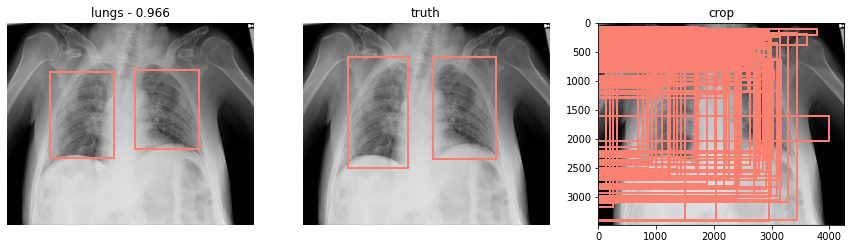

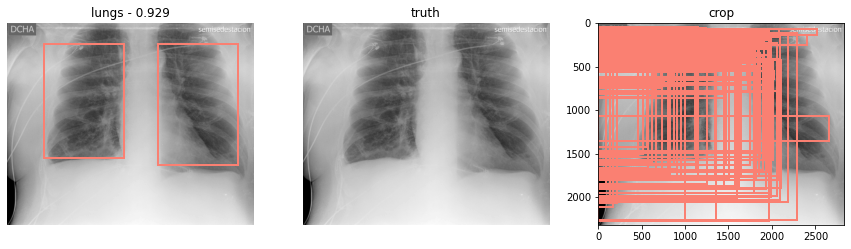

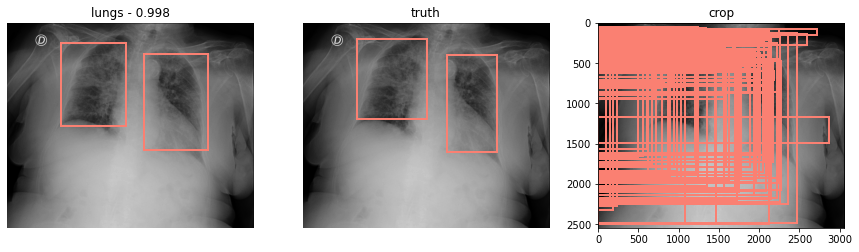

KeyboardInterrupt: 

In [92]:
boxes_lungs, boxes_truth, boxes_lungs = [], [], []
tps, fns, fps = 0, 0, 0
boxes_dic_for_crop = {}

for i in tqdm(range(len(df))):
    lungs = np.array(df['boxes_lung'][i])
    truth = np.array(df['boxes'][i])
    pred = np.array(df['boxes_yolo'][i])
    starts = np.array(df['crop_starts'][i])

    shape_crop = df['shape_crop'][i]
    shape = df['shape'][i]
    
    truth = Boxes(truth, shape, bbox_format="coco")["albu"]
    
    pred = Boxes(pred[:, 2:], shape, bbox_format="coco")["albu"]

    # LUNGS
    lungs = Boxes(lungs, shape_crop, bbox_format="albu")["coco"]
    
    if len(lungs):
        lungs[:, 0] += starts[1]
        lungs[:, 1] += starts[0]

    if COMPUTE_CROPS:
        lungs_ = Boxes(lungs.copy(), shape, bbox_format="coco")["pascal_voc"]
        
        x_start = lungs_[:, 0].min()
        y_start = lungs_[:, 1].min()
        x_end = lungs_[:, 2].max()
        y_end = lungs_[:, 3].max()

        lungs_for_crop = Boxes(np.array([[x_start, y_start, x_end, y_end]]), shape, bbox_format="pascal_voc")
#         lungs_for_crop.expand(1.2)
        boxes_dic[df["image_id"][i]] = lungs_for_crop["pascal_voc"].tolist()

    lungs = Boxes(lungs, shape, bbox_format="coco")
    lungs = expand_boxes(lungs, 0.75)["albu"]
    
    confidence = pred_oof[i]
#     confidence = df['img_target'][i]
    
    bl = []
    for b in lungs:
        bl.append([
            df["image_id"][i], "opacity", confidence, b[0], b[2], b[1], b[3]
        ])
    boxes_lungs += bl

    bt = []
    for b in truth:
        bt.append([
            df["image_id"][i], "opacity", b[0], b[2], b[1], b[3]
        ])
    boxes_truth += bt
    
    bp = []
    for b in pred:
#         print(b)
#         print(xxx)
        bp.append([
            df["image_id"][i], "opacity", b[1], b[2], b[3], b[4], b[5]
        ])
    boxes_pred += bp

    if COMPUTE_MAP:
        if len(bt):
            ap = mean_average_precision_for_boxes(bt, bp, verbose=0)[0]
        else:
            ap = 0
        print(f' -> mAP : {ap:.3f}')

        if confidence > 0.5:
            if ap == 1:
                tps += 2
            elif 0 < ap < 1:  # 1 correct, rest wrong
                tps += 1
                fns += len(bt) - 1
                fps += 1
            else:  # 2 wrong
                fps += 2
                fns += len(bt)
        else:
            fns += len(bt)

    if PLOT:  # or 0 < ap < 1:
        if np.max(starts) >= -1: # 100:
            xray_path = DATA_PATH + "train/" + df["study_id"][i] + "/" + df['series_id'][i] + "/" + df["image_id"][i] + ".dcm"
            image, _ = read_xray(xray_path)

            plt.figure(figsize=(15, 7))
            plt.subplot(1, 3, 1)
            plot_sample(image, lungs, bbox_format="albu")
            plt.title(f'lungs - {confidence :.3f}')
            
            plt.subplot(1, 3, 2)
            plot_sample(image, truth, bbox_format="albu")
            plt.title('truth')
            
            plt.subplot(1, 3, 3)
            plot_sample(image, pred, bbox_format="albu")
            plt.title('crop')
            plt.axis(True)

            plt.show()

        if i > 10:
            break

if COMPUTE_CROPS and len(boxes_dic) == len(df):
    json.dump(boxes_dic, open("../output/boxes_dic.json", "w"))

# Score

In [89]:
mean_average_precision_for_boxes(boxes_truth, boxes_pred)

Number of files in annotations: 4510
Number of files in predictions: 6333
Unique classes: 1
Detections length: 6333
Annotations length: 4510
opacity                        | 0.168842 |    8257
mAP: 0.168842


(0.1688420241086771, {'opacity': (0.1688420241086771, 8257.0)})

In [78]:
boxes_pred

[['000a312787f2',
  'opacity',
  0.9655568599700928,
  0.17175751879699247,
  0.4344454887218045,
  0.24139908256880735,
  0.669151376146789],
 ['000a312787f2',
  'opacity',
  0.9655568599700928,
  0.5176221804511278,
  0.7810150375939849,
  0.2319380733944954,
  0.6258600917431193],
 ['000c3a3f293f',
  'opacity',
  0.9286209344863892,
  0.614406779661017,
  0.9367937853107344,
  0.10431034482758621,
  0.7030172413793103],
 ['000c3a3f293f',
  'opacity',
  0.9286209344863892,
  0.1483050847457627,
  0.4738700564971751,
  0.1021551724137931,
  0.6702586206896551],
 ['0012ff7358bc',
  'opacity',
  0.9977662563323975,
  0.21891361256544503,
  0.48200261780104714,
  0.09669811320754718,
  0.5051100628930818],
 ['0012ff7358bc',
  'opacity',
  0.9977662563323975,
  0.555628272251309,
  0.8154450261780105,
  0.1509433962264151,
  0.6187106918238994],
 ['001398f4ff4f',
  'opacity',
  0.20040182769298553,
  0.2144859813084112,
  0.463785046728972,
  0.17926136363636364,
  0.6872159090909091],
 [